# NYPD Motor Vehicle Collision Data
### Greg DeVore
### October 23rd, 2018

The goal of this writeup is to use SQL to query a public Google BigQuery data set and perform exploratory data analysis on the results. In particular, we'll be querying a database of NYPD motor vehicle collisions from the last six years. The database contains nearly 1.2 million rows, and contains columns for the following data:
* The location of each accident (in terms of borough, street, zip code, and actual geographic coordinates)
* The time of each accident
* The contributing factor (cause of the accident) for up to five vehicles, along with descriptions of the vehicles
* The number of injuries (broken down by motorist, pedestrian, and cyclist) for each accident

The first part of this writeup will consist of pure SQL queries to the database. After that, we'll pull in the raw data and convert the results to a Pandas dataframe. This will allow us to perform more detailed analysis, and begin to visualize our results. In general, exploring the dataset will consist of aggregating and summarizing the data in different ways, creating new features as necessary, and creating plots of interesting findings. In particular, we'll investigate the following:
* What are the most common causes of accidents in NYC?
* How many vehicles are typically involved in an accident?
* Do more accidents occur during a particular time of day? Are there any yearly or monthly trends?
* Have any of the more serious contributing factors (distraction, alcohol, medication) changed over time?
* How have the number of injuries changed over time? Is there any correlation with the number of accidents?
* Are the most common causes of accidents a function of the time of day? Is there any difference between weekdays and the weekend?

After performing the analysis, we will find that:
* The most common cause (over 30% of all accidents), regardless of borough or time of day, is driver inattentiveness.
* The vast majority of accidents (about 80%) involve two vehicles. Accidents involving a single vehicle, or three or more vehicles, are quite rare.
* Most accidents (over 30%) happen in the afternoon (from 12-5pm).
* The number of accidents per year was relatively unchanged from 2013-2015, but has been decreasing for the past two years.
* The number of accidents caused by intentional distraction or impairment (including alcohol and prescription medications) has been decreasing since 2016 (although this isn't completely certain).
* Most boroughs have shown decreases across the board in terms of the number of accidents and all forms of injuries, with just a few exceptions.
* The most common causes of accidents are generally not a function of the time of day. The only major exception is that alcohol related accidents are more common over night and on the weekends.

## Querying collision data from the Google database

The first step, after importing the relevant Python libraries, is to use SQL to query the Google BigQuery database.

In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

To do this, we need to add the key that's required to access Google's database as an environment variable.

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/gdevore21/Documents/Projects/BigDataAPI-GHD-f626275203e9.json'

Now, we can start a client, which we can then send our SQL queries to.

In [3]:
client = bigquery.Client()

To start, let's do something simple and count the total number of accidents per borough, using the column 'contributing_factor_vehicle_1' as a proxy. We'll group the accidents by borough and sort by the number of accidents.

In [4]:
# Total number of incidents in each borough
query_job = client.query("""
    SELECT borough, COUNT(contributing_factor_vehicle_1) AS count FROM `bigquery-public-data.new_york.nypd_mv_collisions`
    WHERE contributing_factor_vehicle_1 <> '' AND borough <> ''
    GROUP BY borough
    ORDER BY count DESC
    """)
results = query_job.result()
df = results.to_dataframe()
print(df)

         borough   count
0       BROOKLYN  262321
1         QUEENS  223270
2      MANHATTAN  214382
3          BRONX  113782
4  STATEN ISLAND   39332


Brooklyn has the highest number of accidents, followed by Queens and Manhattan. Let's compare these numbers to the population of each borough (2017 estimates):
* Brooklyn: 2.6 million people
* Queens: 2.4 million people
* Manhattan: 1.7 million people
* Bronx: 1.5 million
* Staten Island: 0.5 million people

Perhaps not surprisingly, there is a strong correlation between borough population and the number of accidents that occur there. One interesting observation is that despite having a significantly lower population than Queens, Manhattan has nearly as many accidents. This could be because Manhattan is more densely populated than any of the other boroughs.

Next, let's look at the most common causes of accidents. The one catch to this, which will come up again during our detailed analysis, is that there is a category labeled 'Unspecified', which in some years accounts for nearly 60% of all accidents. This makes it difficult to explore how causes of accidents change over time, as it is unclear why the cause of a particular accident would be labeled 'Unspecified', or if in fact there is any pattern to this labeling. Despite this, there are still valuable insights to be gained from the dataset.

In [5]:
# Most frequent incidents across all boroughs (top 10)
query_job = client.query("""
    SELECT contributing_factor_vehicle_1, COUNT(contributing_factor_vehicle_1) AS count FROM `bigquery-public-data.new_york.nypd_mv_collisions`
    WHERE contributing_factor_vehicle_1 <> '' AND borough <> ''
    GROUP BY contributing_factor_vehicle_1
    ORDER BY count DESC
    LIMIT 10
    """) 
results = query_job.result()
df = results.to_dataframe()
print(df)

    contributing_factor_vehicle_1   count
0                     Unspecified  435796
1  Driver Inattention/Distraction  120645
2   Failure to Yield Right-of-Way   44302
3                Backing Unsafely   29877
4                 Other Vehicular   27291
5                 Fatigued/Drowsy   26190
6              Turning Improperly   18649
7              Lost Consciousness   15823
8         Prescription Medication   13275
9           Following Too Closely   13270


As mentioned above, the most common reported cause is 'Unspecified', but after that, the second most common cause, which is 3x more common than the third, is distracted driving. Also on the list are several factors related to 'bad' driving, such as failure to yield, backing unsafely, turning improperly, and following too closely.

Our final SQL query, before pulling in raw data and transitioning to Pandas, will be to see if distracted driving is the most common cause of accidents across all boroughs. To do this, we'll first need to first perform a query to count the number of occurrences for all incidents, grouped by borough and cause. Then, we'll need to join this with a query that selects the most frequent occurrence from the same query, with the results grouped by borough only. The join will be made where the boroughs match, and the number of occurrences from the first query match the most frequent number from the second. Also, we'll want to remove 'Unspecified' accidents from any result, as these are not helpful for this particular query.

In [6]:
# Most frequent incident by borough
query_job = client.query("""
SELECT t1.borough, t1.contributing_factor_vehicle_1, t1.numOccurrences
FROM(
  SELECT borough, contributing_factor_vehicle_1, COUNT(*) AS numOccurrences
  FROM `bigquery-public-data.new_york.nypd_mv_collisions`
  WHERE contributing_factor_vehicle_1 NOT IN ('Unspecified','') AND borough <> '' 
  GROUP BY borough, contributing_factor_vehicle_1) t1
JOIN(
  SELECT borough, MAX(numOccurrences) AS largestCount
  FROM(
    SELECT borough, contributing_factor_vehicle_1, COUNT(*) AS numOccurrences
    FROM `bigquery-public-data.new_york.nypd_mv_collisions`
    WHERE contributing_factor_vehicle_1 NOT IN ('Unspecified','') AND borough <> ''
    GROUP BY borough, contributing_factor_vehicle_1) tmp
  GROUP BY borough) t2
ON t2.borough = t1.borough AND t2.largestCount = t1.numOccurrences
ORDER BY t1.numOccurrences DESC;
    """)
results = query_job.result()
df = results.to_dataframe()
print(df)

         borough   contributing_factor_vehicle_1  numOccurrences
0         QUEENS  Driver Inattention/Distraction           35360
1      MANHATTAN  Driver Inattention/Distraction           34731
2       BROOKLYN  Driver Inattention/Distraction           30524
3          BRONX  Driver Inattention/Distraction           14248
4  STATEN ISLAND  Driver Inattention/Distraction            5782


The results above show that distracted driving is the most common cause of accidents across all five boroughs.

## Pulling the data into a Pandas dataframe for further analysis

We're ready to move to more advanced analysis. To do this, let's run a general query on a larger list of columns and convert the results to a Pandas dataframe. We want to focus on the general location (borough only), cause, frequency, and injuries relating to an accident, so we'll pull in the following columns:
* borough
* contributing_factor_vehicle_1
* contributing_factor_vehicle_2
* contributing_factor_vehicle_3
* contributing_factor_vehicle_4
* contributing_factor_vehicle_5
* timestamp
* number_of_cyclist_injured 
* number_of_motorist_injured
* number_of_pedestrians_injured 
* number_of_persons_injured 

In [8]:
# All data for more advanced analysis
query_job = client.query("""
    SELECT borough, contributing_factor_vehicle_1, contributing_factor_vehicle_2, contributing_factor_vehicle_3, contributing_factor_vehicle_4, contributing_factor_vehicle_5, timestamp, number_of_cyclist_injured, number_of_motorist_injured, number_of_pedestrians_injured, number_of_persons_injured FROM `bigquery-public-data.new_york.nypd_mv_collisions`
    WHERE contributing_factor_vehicle_1 <> '' AND borough <> ''
    """)
results = query_job.result()
df = results.to_dataframe()

## Common causes of accidents across all boroughs

As a first step, let's look at all of the various causes of an accident, calculated as a percentage of the total number. Here, we'll exclude 'Unspecified'.

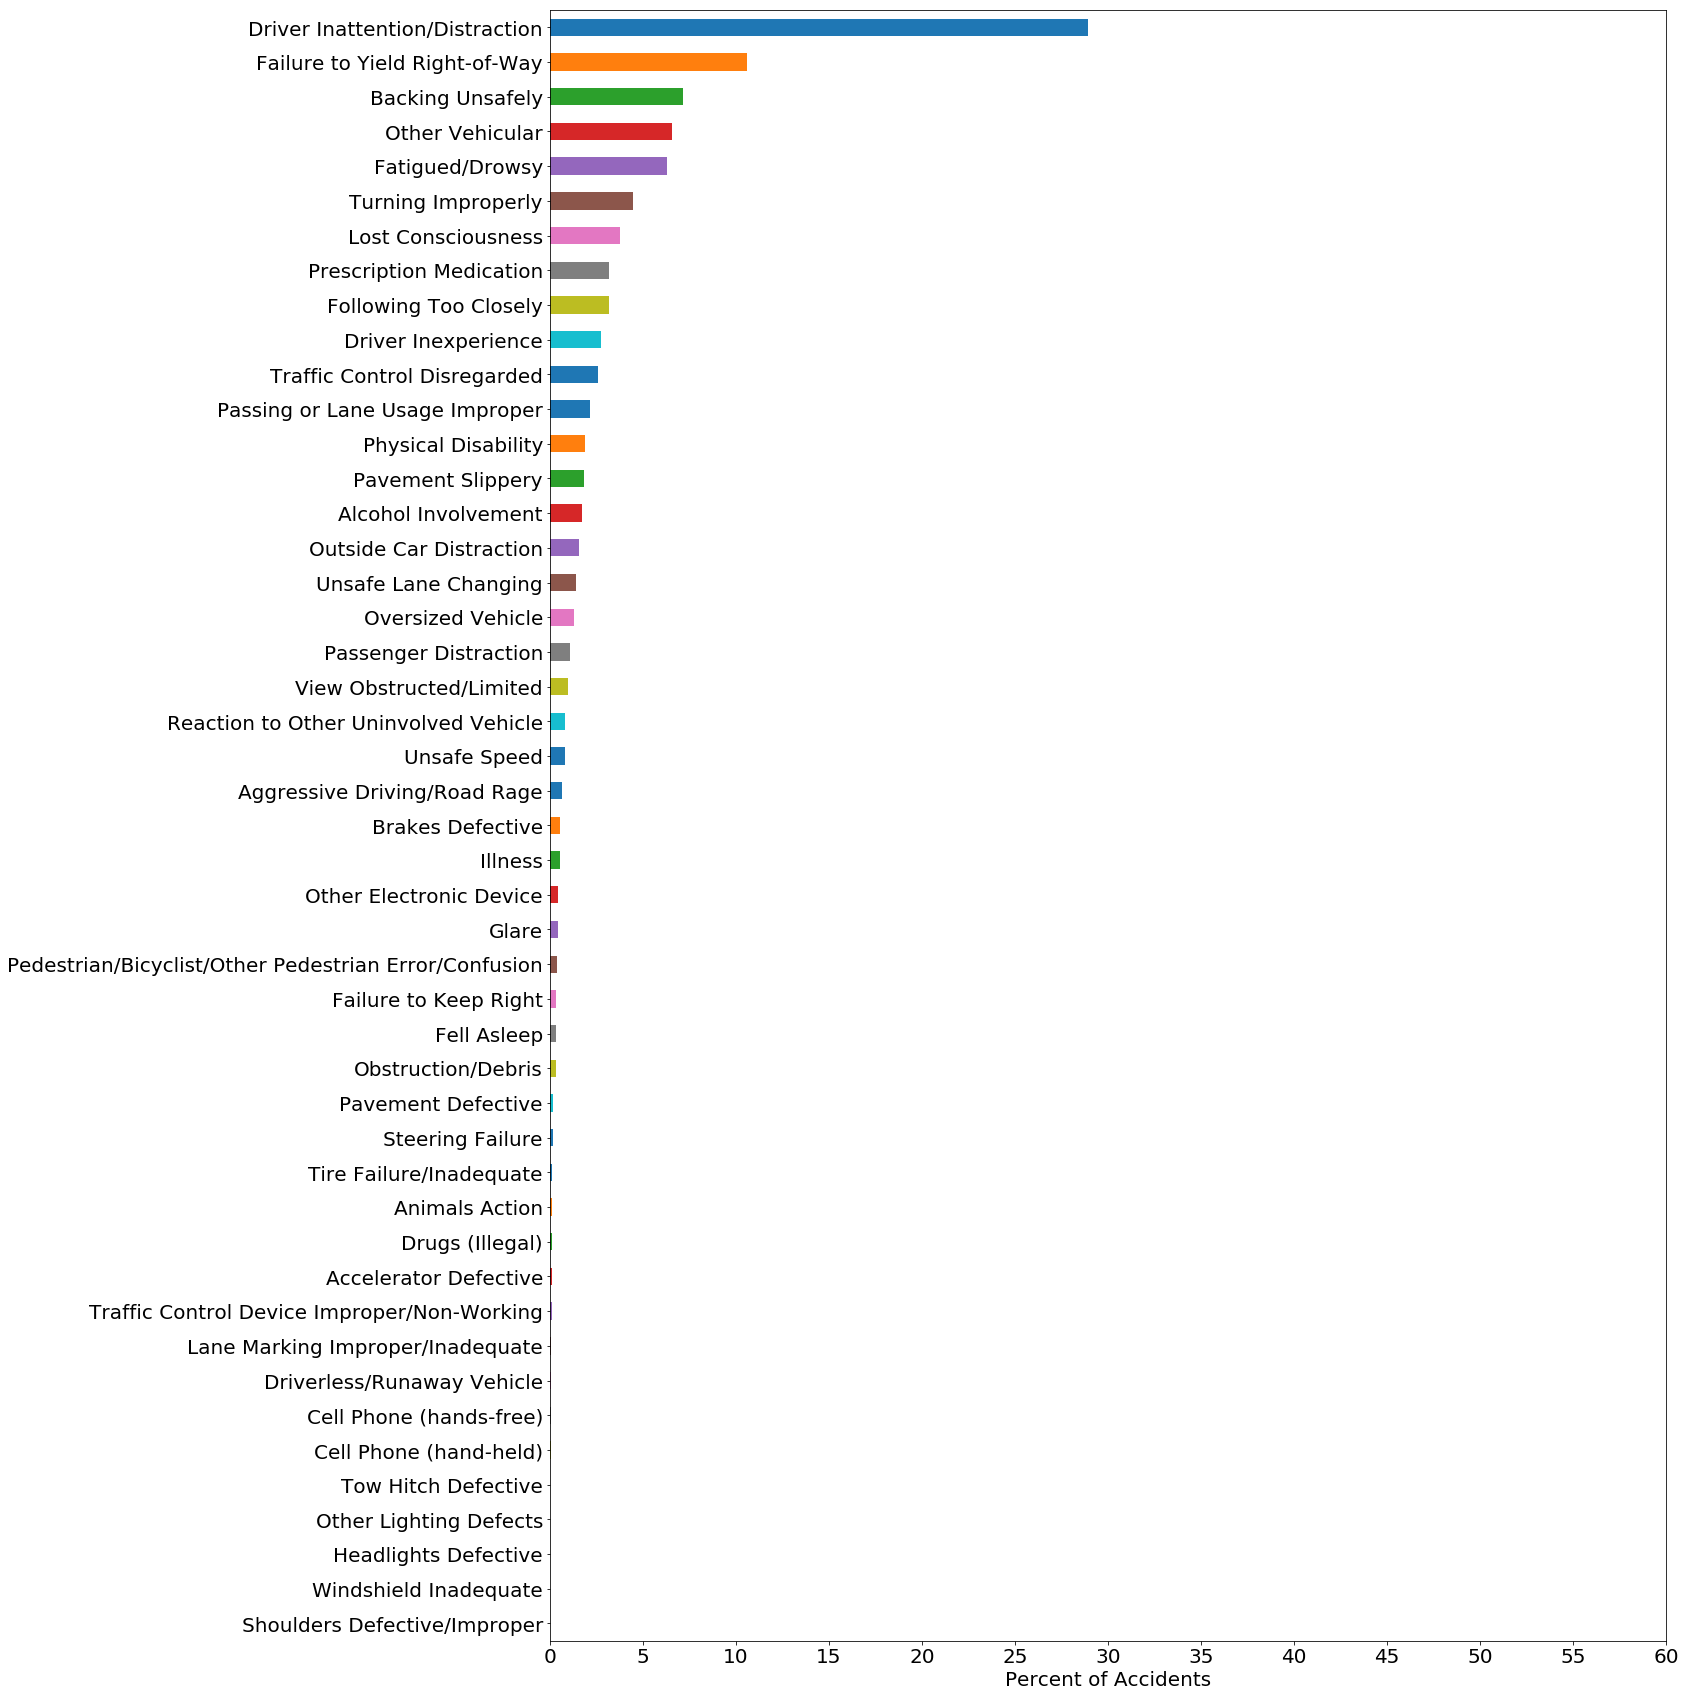

In [9]:
factor_counts = df['contributing_factor_vehicle_1'].value_counts()
factor_counts = factor_counts.drop('Unspecified')
factor_counts /= sum(factor_counts) / 100
plt.figure(figsize=(20,30))
factor_counts.plot('barh').invert_yaxis()
plt.xlabel('Percent of Accidents', fontsize=20)
plt.xlim(0,60)
plt.xticks(range(0,61,5))
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.draw()

Driver distraction accounts for nearly 30% of all accidents, and the following three causes, which all involve poor driving judgement, account for almost another 30%. All other individual causes each account for only 5% or less of all accidents.

## Engineering new features for more detailed analysis

We know the dataset contains information from the last 6 years, but let's see exactly what timespan is covered. To do that, we need to look at the 'timestamp' column. Querying the min and max values will give us the range.

In [10]:
df['timestamp'].min()

Timestamp('2012-07-01 00:05:00+0000', tz='UTC')

In [11]:
df['timestamp'].max()

Timestamp('2018-01-21 23:56:00+0000', tz='UTC')

It appears that we have data from July 2012 to January 2018. These are timestamp objects, which have methods built in for automatically extracting the year, month, day, etc. We can use these to create new columns for year and month, and use the day of the week (integer value from 0 to 6) to determine if an accident occurred on a weekend or during the week.

In [12]:
df['year'] = df['timestamp'].apply(lambda x: x.date().year)
df['month'] = df['timestamp'].apply(lambda x: x.date().month)
df['is_weekend'] = df['timestamp'].apply(lambda x: x.weekday() > 4)

Because we will be looking at many trends by year, let's remove the partial years of 2012 and 2018.

In [13]:
df.drop(df[(df.year == 2012) | (df.year == 2018)].index, inplace=True)

Now that we've filtered our data, let's further expand our features by adding one that represents the time of day that an accident occurred. We'll use the following convention:
* 6am-12pm - Morning
* 12pm-5pm - Afternoon
* 5pm-10pm - Evening
* 10pm-2am - Latenight
* 2pm-6am - Overnight

In [14]:
hour = df['timestamp'].apply(lambda x: x.hour)
df['time_of_day'] = ''
df.loc[(hour >= 6) & (hour < 12),'time_of_day'] = 'morning'
df.loc[(hour >= 12) & (hour < 17),'time_of_day'] = 'afternoon'
df.loc[(hour >= 17) & (hour < 22),'time_of_day'] = 'evening'
df.loc[(hour >= 22) | (hour < 2),'time_of_day'] = 'latenight'
df.loc[(hour >= 2) & (hour < 6),'time_of_day'] = 'overnight'

Let's also add a feature for the number of vehicles that were involved in an accident. To do this, we can look for rows where the contributing factor was not blank. Here, we're assuming a blank column means that a vehicle was not involved in the accident (a reasonably safe assumption). We'll create a binary variable for each vehicle, where a one indicates involvement, and a zero indicates the vehicle was not present. The sum of these five columns will give us the total vehicle count for each accident.

In [15]:
vehicle1 = df['contributing_factor_vehicle_1'] != ''
vehicle2 = df['contributing_factor_vehicle_2'] != ''
vehicle3 = df['contributing_factor_vehicle_3'] != ''
vehicle4 = df['contributing_factor_vehicle_4'] != ''
vehicle5 = df['contributing_factor_vehicle_5'] != ''
vehicle1 = vehicle1.astype(int)
vehicle2 = vehicle2.astype(int)
vehicle3 = vehicle3.astype(int)
vehicle4 = vehicle4.astype(int)
vehicle5 = vehicle5.astype(int)
df['num_vehicles'] = vehicle1 + vehicle2 + vehicle3 + vehicle4 + vehicle5

## Number of vehicles involved in an accident

Now that we've added some new features, we can start to make some more complex visualizations with our data. For example, how many cars are typically involved in an accident?

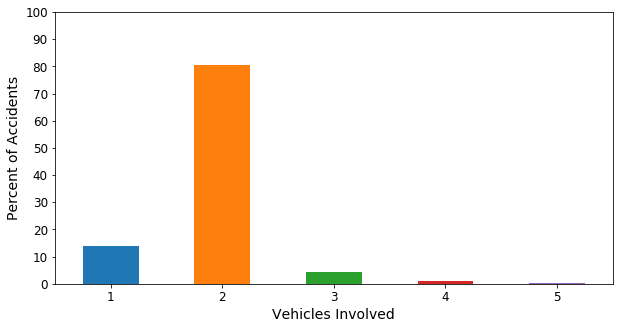

In [16]:
plt.figure(figsize=(10,5))
num_vehicles = df['num_vehicles'].value_counts().sort_index()
num_vehicles /= sum(num_vehicles) / 100
num_vehicles.plot('bar').invert_yaxis()
plt.xlabel('Vehicles Involved', fontsize=14)
plt.ylabel('Percent of Accidents', fontsize=14)
plt.ylim(0,100)
plt.yticks(range(0,101,10))
plt.xticks(rotation=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.draw()

Not surprisingly, just over 80% of all accidents involve only two vehicles. Single vehicle accidents are the next most common (around 15%), but accidents involving three or more vehicles account for only about 5% of all accidents.

## Number of accidents as a function of time

Next, let's look at the frequency of accidents at different times of day, as well as yearly and monthly trends.

First, do accidents occur more often during a certain time of day?

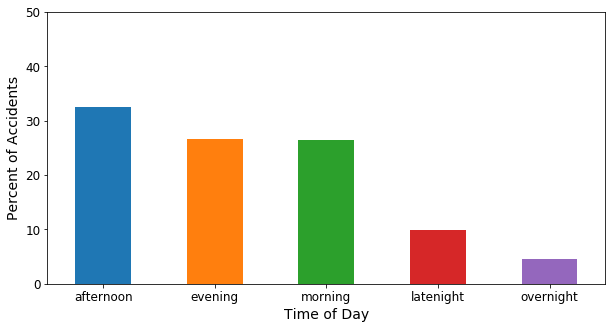

In [17]:
plt.figure(figsize=(10,5))
time_of_day = df['time_of_day'].value_counts()
time_of_day /= sum(time_of_day) / 100
time_of_day.plot('bar').invert_yaxis()
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Percent of Accidents', fontsize=14)
plt.ylim(0,50)
plt.yticks(range(0,51,10))
plt.xticks(rotation=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.draw()

Most accidents (about 33%) occur in the afternoon (between 12pm and 5pm), most likely because more people are out and about during this time of day. Morning and evening accidents (6am-12pm and 5pm-10pm, respectively) are the next most common, accounting for a combined total of around 50% of all accidents. Latenight and overnight accidents are the least common, accounting for just about 15% of all accidents. This is not too surprising because this is when the fewest cars are on the road.

Next, has the number of accidents changed year over year?

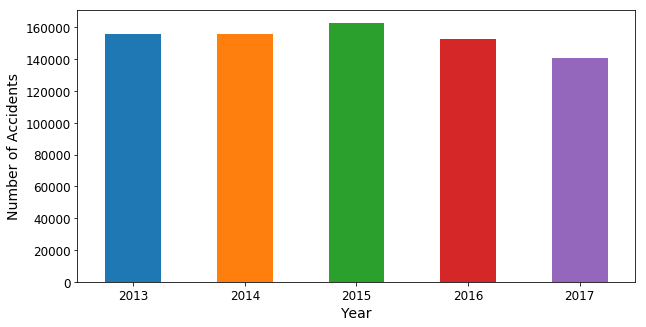

In [18]:
plt.figure(figsize=(10,5))
year = df['year'].value_counts().sort_index()
year.plot('bar')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(rotation=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.draw()

Interestingly, the number of accidents was increasing until 2015, but has seen a noticeable decrease since then. Given the clear trend in yearly accident numbers, is there a significant monthly factor?

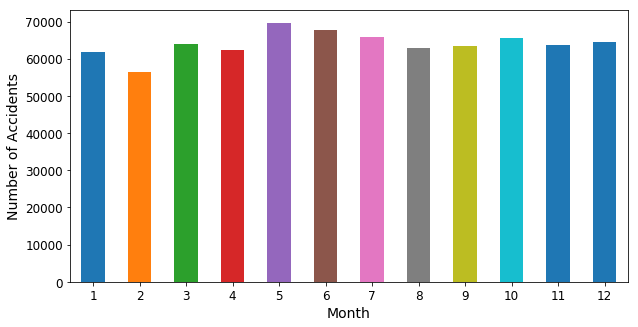

In [19]:
plt.figure(figsize=(10,5))
month = df['month'].value_counts().sort_index()
month.plot('bar')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(rotation=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.draw()

There is some definitely some variability, most accidents occur during the late spring and early summer (May through July), and the fewest occur during the winter (January and February), there are no clear outliers in terms of monthly accident numbers.

## Changes in contributing factors over time

Next, let's take a look at how a few of the contributing factors have changed over time. In particular, let's look at yearly totals for accidents involving driver distraction, alcohol consumption, and prescription medication. As a check, we'll also look at accidents labeled 'Unspecified'.

In [20]:
grouped = df.groupby(['contributing_factor_vehicle_1','year'])['contributing_factor_vehicle_1'].count()
distraction = grouped['Driver Inattention/Distraction']
unspecified = grouped['Unspecified']
alcohol = grouped['Alcohol Involvement']
medication = grouped['Prescription Medication']
year_totals = df.groupby(['year'])['contributing_factor_vehicle_1'].count()

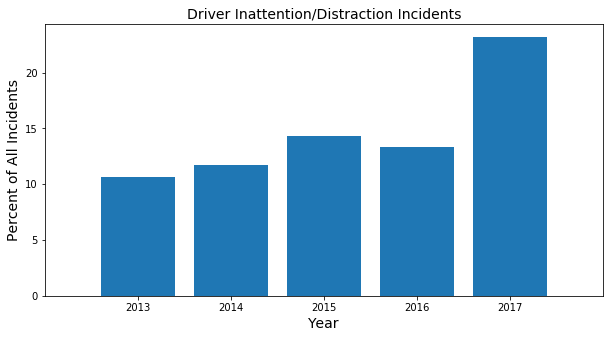

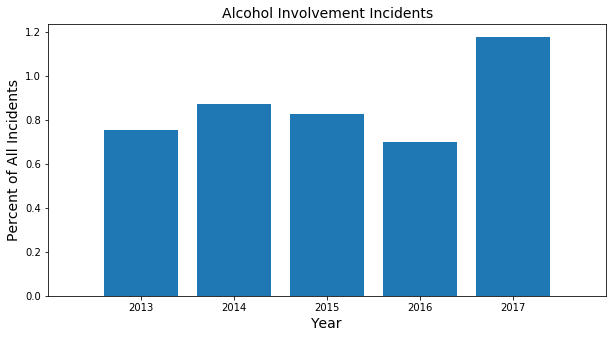

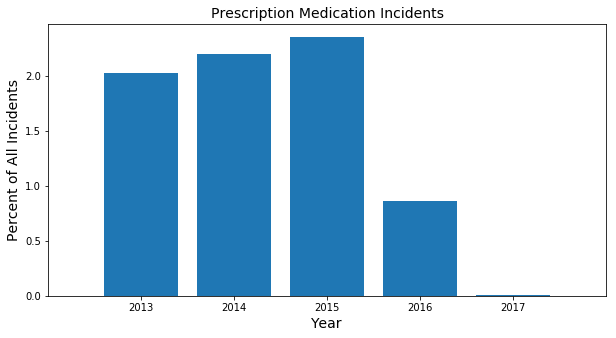

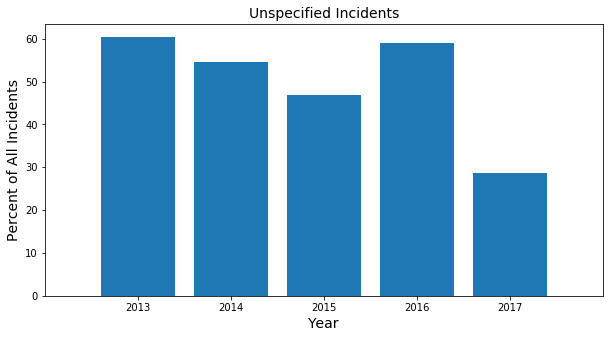

In [21]:
factors = ('Driver Inattention/Distraction','Alcohol Involvement','Prescription Medication','Unspecified')
for factor in factors:
    percent = grouped[factor]/year_totals * 100
    plt.figure(figsize=(10,5))
    plt.bar(range(5),percent)
    plt.title('%s Incidents' % factor, fontsize=14)
    plt.xticks(range(5),range(2013,2018))
    plt.xlabel('Year', fontsize=14)
    plt.xlim(-1,5)
    plt.ylabel('Percent of All Incidents', fontsize=14)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    plt.draw()

Accidents resulting from driver distraction show an increase until 2015, then a slight decrease in 2016, followed by a large increase in 2017. Those involving alcohol show a similar trend, except the decrease starts in 2015. Those involving prescription medication had been increasing until 2016, when they showed a sharp decrease, and 2017 showed almost zero accidents. The one thing each of these three factors has in common is erroneous behavior in 2017, either a sharp increase or decrease. If we look at the number of accidents designated as 'Unspecified', we see a large drop in 2017 (from nearly 60% of all accidents to just under 30%). All of these accidents were designated as something other than 'Unspecified', so we can't say for certain if any of the 2017 trends observed in the first three plots are valid. However, it is safe to say that they were all decreasing up until that point, and hopefully continue to do so.

## Changes in motorist, pedestrian, and cyclist injuries within each borough over time

Next, let's look at the number of injuries for motorists, pedestrians, and cyclists within each borough, and how these numbers have changed within the last four years. We'll also plot the total number of accidents for comparison.

In [22]:
boroughs = list(df['borough'].unique())
boroughs.sort()
plot_data = ('contributing_factor_vehicle_1','number_of_persons_injured','number_of_motorist_injured','number_of_cyclist_injured','number_of_pedestrians_injured')
plot_labels = ('Total Accidents','Total Injuries','Motorist Injuries','Cyclist Injuries','Pedestrians Injuries')

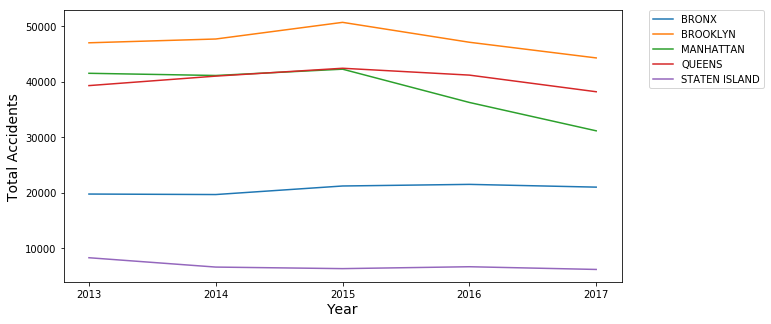

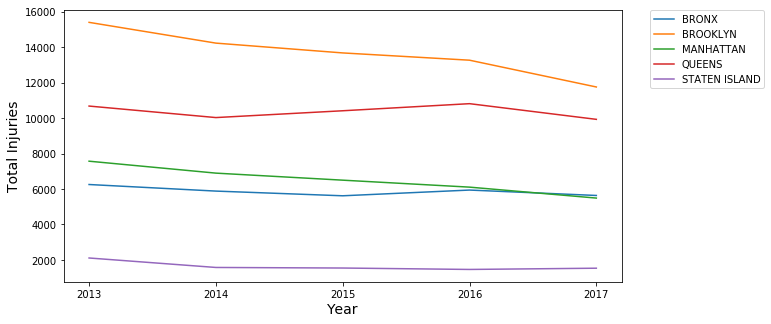

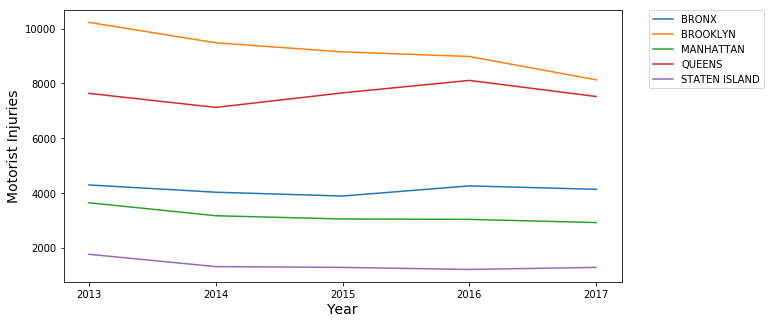

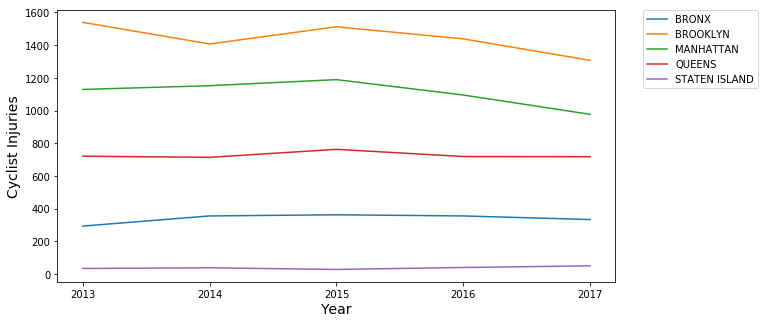

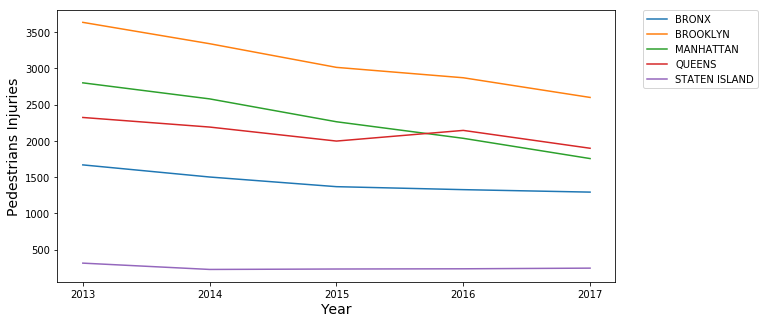

In [23]:
for index,label in enumerate(plot_data):
    if index == 0:
        data = df.groupby(['borough','year'])[label].count()
    else:
        data = df.groupby(['borough','year'])[label].sum()
    plt.figure(figsize=(10,5))
    for borough in boroughs:
        data[borough].plot('line')
    plt.xlabel('Year', fontsize=14)
    plt.xticks(range(2013,2018))
    plt.ylabel(plot_labels[index], fontsize=14)
    plt.legend(boroughs,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    plt.draw()

Looking at the total number of accidents, we can see that they were increasing for most boroughs until 2015, and have been decreasing since. The total number of injuries have thankfully been decreasing for all boroughs since 2013. Looking at the breakdown in injury type, we see that while motorist and pedestrian injuries have been steadily decreasing, the trend for cyclist injuries aren't quite as clear. To help with the analysis, the percent change between 2013 and 2017 for each of the five quantities is shown below.

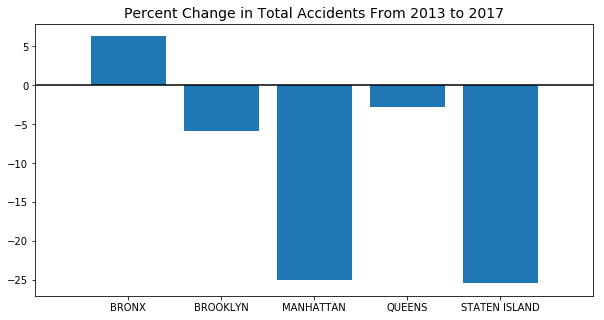

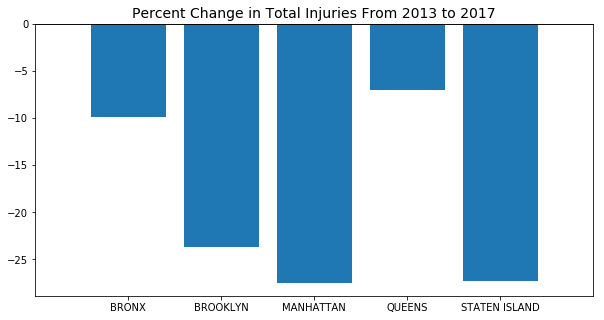

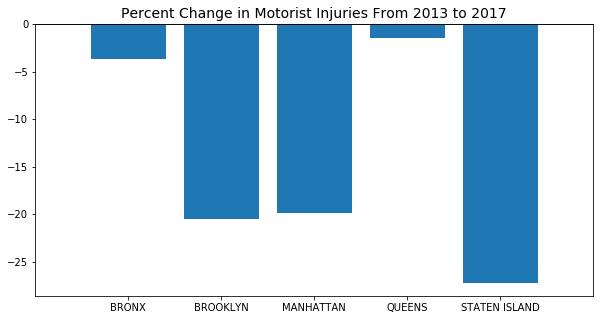

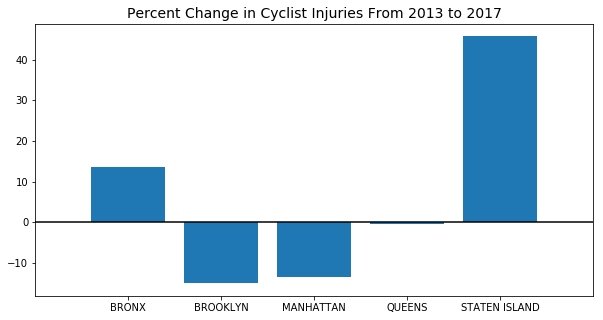

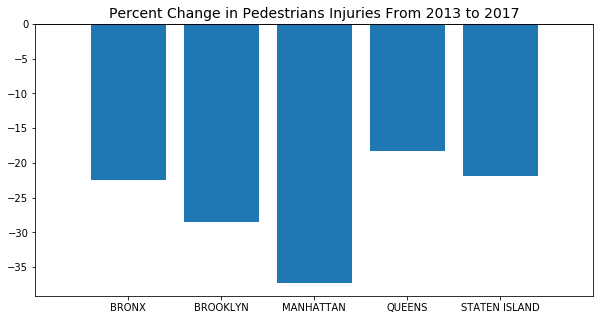

In [24]:
for index,label in enumerate(plot_data):
    if index == 0:
        data = df.groupby(['borough','year'])[label].count()
    else:
        data = df.groupby(['borough','year'])[label].sum()
    percent_change = []
    plt.figure(figsize=(10,5))
    for borough in boroughs:
        reference = data[borough].values[0]
        current = data[borough].values[-1]
        percent_change.append((current/reference - 1) * 100)
    plt.bar(range(5),percent_change)
    plt.title('Percent Change in %s From 2013 to 2017' % plot_labels[index], fontsize=14)
    plt.xticks(range(5),boroughs)
    plt.xlim(-1,5)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    plt.hlines(0,-1,5)
    plt.draw()

These bar charts definitely make it easier to analyze the changes between 2013 and 2017. Some of the big takeaways include:
* Manhattan and Staten Island have had the largest decrease in accidents since 2013, at around 25% each. The Bronx is the only borough that's seen an increase in the total number of accidents, at just over 5%.
* All five boroughs have seen a decrease in the total number of injuries, with Brooklyn, Manhattan, and Staten Island leading the way with around 25% each.
* Changes in motorist injuries show a similar trend to those seen with overall injuries, which is not surprising since most of the injuries in an accident are motorist related.
* Only Brooklyn and Manhattan have seen a decrease in cyclist injuries since 2013. Queens has seen no real change, while the Bronx and Staten Island have actually seen an increase (around 13% and 45%, respectively). The increase in injuries on Staten Island is with respect to a smaller number (see the first set of line charts), but a 45% increase is still troublesome.
* All five boroughs have shown a significant decrease in pedestrian injuries since 2013 (all at least 20%), with Manhattan leading the way at over 35%.

## Most common causes of accidents as a function of the time of day

Finally, let's look at whether or not the most common causes of accidents change with the time of day. We'll also explore if there is a difference between weekdays and weekends.

In [25]:
dfg = df.groupby(['time_of_day','contributing_factor_vehicle_1'])['contributing_factor_vehicle_1'].count().reset_index(name='count')
dfg.drop(dfg[(dfg.contributing_factor_vehicle_1 == 'Unspecified')].index, inplace=True)
dfgg = dfg.sort_values(['time_of_day','count'],ascending=False).groupby('time_of_day').head(10)

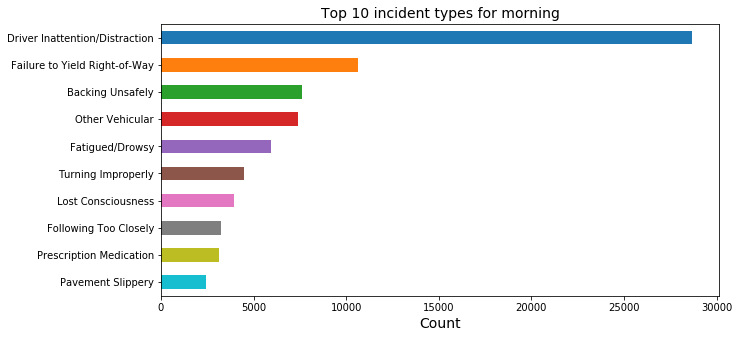

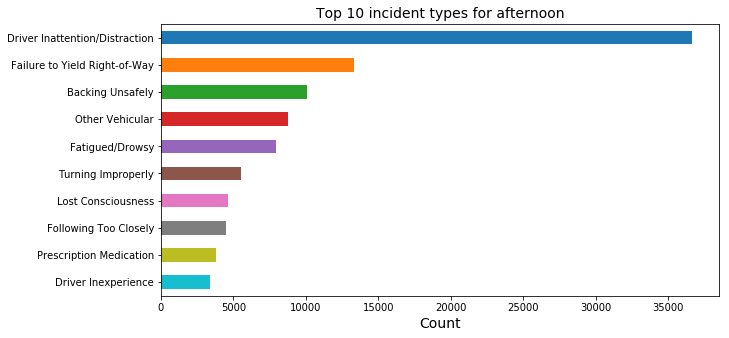

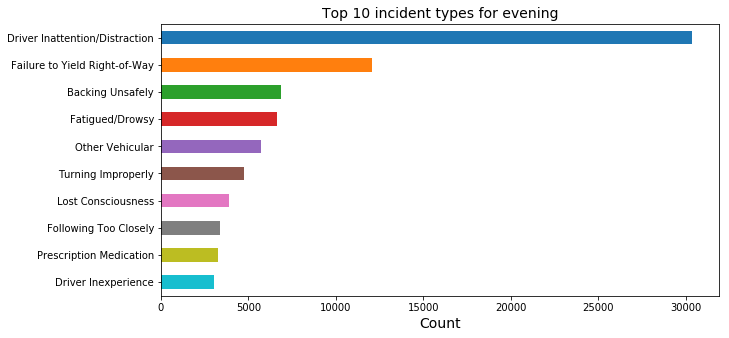

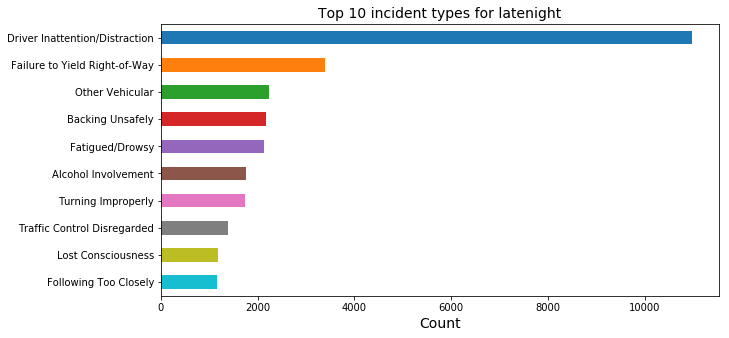

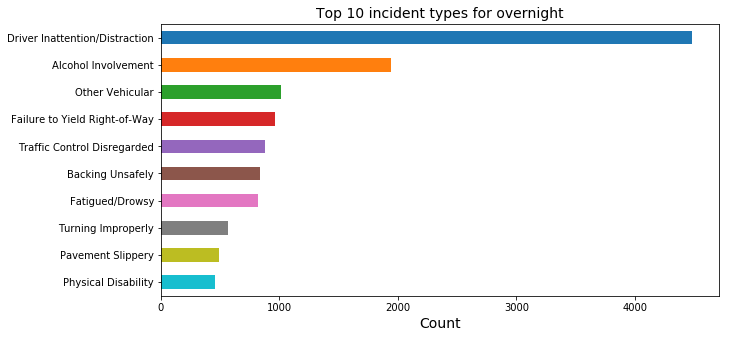

In [26]:
times = ('morning','afternoon','evening','latenight','overnight')
for time in times:
    plt.figure(figsize=(10,5))
    dfgg.loc[(dfgg.time_of_day == time),'count'].plot('barh').invert_yaxis()
    labels = list(dfgg.loc[(dfgg.time_of_day == time),'contributing_factor_vehicle_1'].values)
    plt.title('Top 10 incident types for %s' % time, fontsize=14)
    plt.xlabel('Count', fontsize=14)
    plt.yticks(range(10),labels)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    plt.draw()

The top 10 incidents do not change in the morning, afternoon, or evening (technically the order changes slightly, but the 10 incidents are the same). For latenight accidents however, alcohol involvement and disregarding traffic controls enter the top 10 (at numbers six and eight, respectively). For overnight accidents, alcohol jumps to the number two most common cause, and disregarding traffic controls jumps to number five. This is a serious change, and shows just how much more prevalent alcohol related traffic incidents are after dark.

Let's take a look at whether or not there is a similar trend on weekdays versus weekends.

In [27]:
dfg = df.groupby(['is_weekend','contributing_factor_vehicle_1'])['contributing_factor_vehicle_1'].count().reset_index(name='count')
dfg.drop(dfg[(dfg.contributing_factor_vehicle_1 == 'Unspecified')].index, inplace=True)
dfgg = dfg.sort_values(['is_weekend','count'],ascending=False).groupby('is_weekend').head(10)

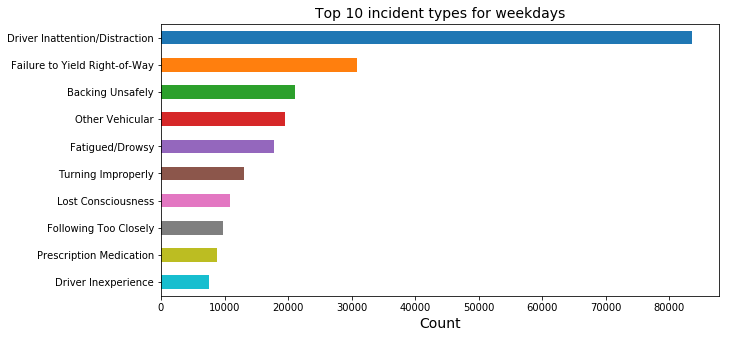

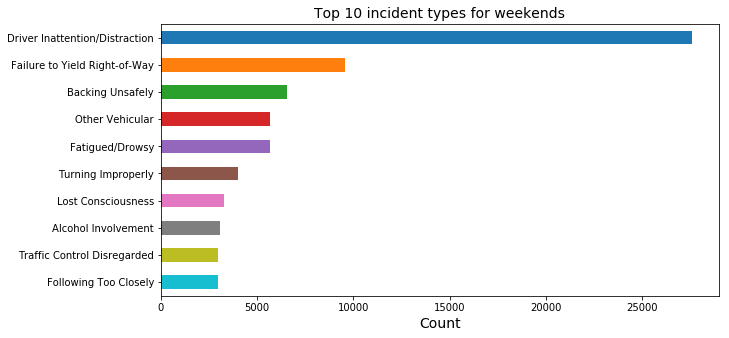

In [28]:
isweekend = (False,True)
for tf in isweekend:
    plt.figure(figsize=(10,5))
    dfgg.loc[(dfgg.is_weekend == tf),'count'].plot('barh').invert_yaxis()
    labels = list(dfgg.loc[(dfgg.is_weekend == tf),'contributing_factor_vehicle_1'].values)
    if tf:
        plt.title('Top 10 incident types for weekends', fontsize=14)
    else:
        plt.title('Top 10 incident types for weekdays', fontsize=14)
    plt.xlabel('Count', fontsize=14)
    plt.yticks(range(10),labels)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    plt.draw()

There is a similar effect here, alcohol involvement and disregarding traffic controls are among the top 10 most common causes on weekends, but not on weekdays.

## Summary and Conclusion

Our goal for this writeup was to use SQL to query a public Google BigQuery data set for NYPD motor vehicle collisions and perform exploratory data analysis on the results. After performing our analysis, we found that:
* The most common cause (over 30% of all accidents), regardless of borough or time of day, is driver inattentiveness.
* The vast majority of accidents (about 80%) involve two vehicles. Accidents involving a single vehicle, or three or more vehicles, are quite rare.
* Most accidents (over 30%) happen in the afternoon (from 12-5pm).
* The number of accidents per year was relatively unchanged from 2013-2015, but has been decreasing for the past two years.
* The number of accidents caused by intentional distraction or impairment (including alcohol and prescription medications) has been decreasing since 2016 (although this isn't completely certain).
* Most boroughs have shown decreases across the board in terms of the number of accidents and all forms of injuries, with just a few exceptions.
* The most common causes of accidents are generally not a function of the time of day. The only major exception is that alcohol related accidents are more common over night and on the weekends.